In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

In [2]:
file_train_text = "../../data/training_text/training_text"
file_train_variant = "../../data/training_variants/training_variants"

In [203]:
train_text = pd.read_csv(file_train_text, sep = '\|\|')
train_text.index.name = "ID"
train_text.columns = ["Text"]

train_variant = pd.read_csv(file_train_variant)
train_variant.set_index("ID",inplace = True)

/home/ragou/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
train_variant[train_variant["Variation"].isin(["C396R", "H398Q", "Y371H", "K382E", "C381A"])]

,Gene,Variation,Class
ID,,,
8,CBL,Y371H,4
11,CBL,K382E,4
13,CBL,C381A,4
21,CBL,C396R,4


In [5]:
train_variant[train_variant["Variation"] == "Q249E"]

,Gene,Variation,Class
ID,,,
2,CBL,Q249E,2


In [6]:
train_text.loc[[6],]

,Text
ID,
6,Oncogenic mutations in the monomeric Casitas B...


In [7]:
gene_count = train_variant["Gene"].value_counts().loc[lambda x : x > 100].to_dict()

In [8]:
gene_class = train_variant[train_variant["Gene"].isin(gene_count.keys())]

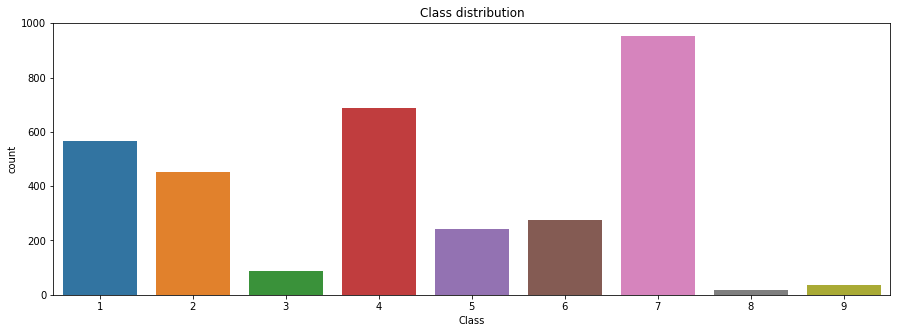

In [9]:
plt.figure(figsize=(15,5))
sns.countplot(x = train_variant["Class"])
plt.title("Class distribution")
plt.show()

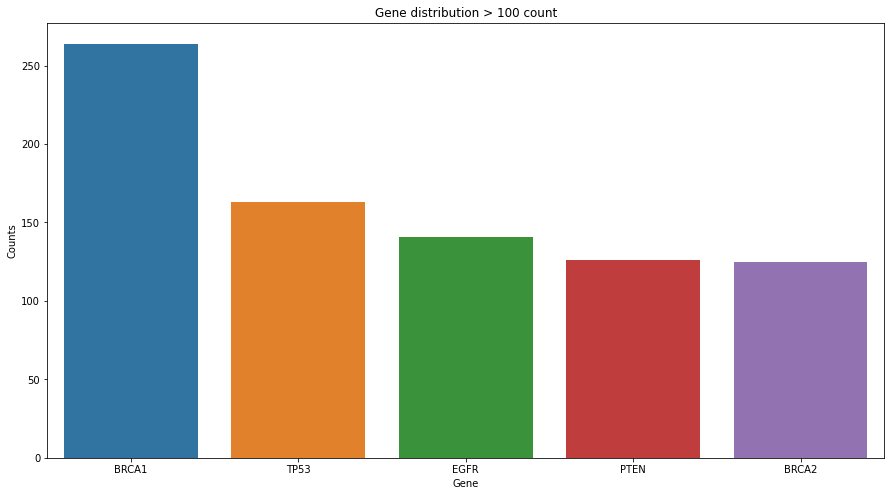

In [10]:
plt.figure(figsize=(15,8))

sns.barplot( x = list(gene_count.keys()), y = list(gene_count.values()))
plt.title("Gene distribution > 100 count")
plt.ylabel("Counts")
plt.xlabel("Gene")

plt.show()

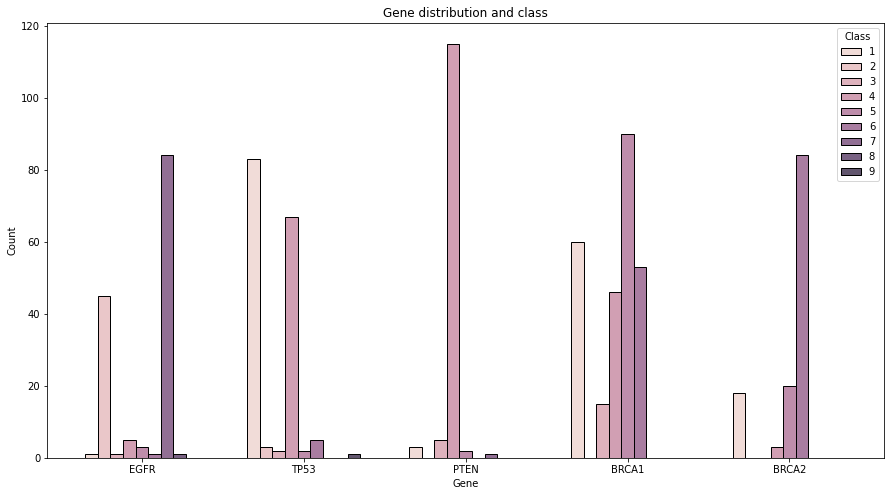

In [11]:
plt.figure(figsize=(15,8))
sns.histplot(data=train_variant[train_variant["Gene"].isin(gene_count.keys())],
             x="Gene", hue="Class", multiple="dodge", shrink=.7)
plt.title("Gene distribution and class")
plt.show()

In [12]:
train_variant.head(5)

,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [200]:
train_variant[train_variant["Gene"] == "RAD51"]

,Gene,Variation,Class
ID,,,


In [7]:
amino_acid_dict = {'C' : 'CYS', 'D' : 'ASP', 'S' : 'SER', 'Q' : 'GLN', 'K' : 'LYS',
    'I' : 'ILE', 'P' : 'PRO', 'T' : 'THR', 'F' : 'PHE', 'N' : 'ASN', 
    'G' : 'GLY', 'H' : 'HIS', 'L' : 'LEU', 'R' : 'ARG', 'W' : 'TRP', 
    'A' : 'ALA', 'V' : 'VAL', 'E' : 'GLU', 'Y' : 'TYR', 'M' : 'MET'}

# Fonction pour la selection

## clean_text
Nettoie l'article, lower puis enlève les points qui pourrait nuire à la detection des phrases, (comme les "...", ou "fig.A")


## find_match
Va détecter la phrase qui contient le mot, puis prend 1 phrase avant et après (au total 3 phrase) (voir diapo)

In [8]:
def amino_three(amino):
    return amino_acid_dict[amino]
    
def decompose_variation(variation):
    decompose_aa_pos_aa = re.compile("([a-z]{1,})(\d+)([a-z]{1,})")
    list_variation = decompose_aa_pos_aa.search(variation)
    if list_variation:
        aa1 = list_variation.group(1)
        aa2 = list_variation.group(3)

        if len(aa1) + len(aa2) == 2:
            amino1 = amino_acid_dict[aa1.upper()].lower()
            position = list_variation.group(2)
            amino2 = amino_acid_dict[aa2.upper()].lower()
            return [amino1,position,amino2]
    return False

def decompose_fusion(variation):
    decompose_g1_g2_fusion = re.compile("(\w+)\s?(\?|-)\s?(\w+)\? fusion")
    list_variation = decompose_g1_g2_fusion.search(variation)
    if list_variation:
        gene1 = list_variation.group(1)
        gene2 = list_variation.group(3)
        print(gene1,gene2,variation, list_variation.group(0))
        return "(" + gene1 + "|" + gene2 + ")"
    return False
        
    

In [543]:
def clean_text(article):
    dot3 = re.compile("[\.]{2,}")
    fig = re.compile("fig[s]?\.")
    decimal = re.compile("\d+\.\d+")    
    etal = re.compile("et al\.")
    ie = re.compile("i\.e\.")
    inc = re.compile("inc\.")
    mutation_point = re.compile("[p|c]\.")
    
    clean_article = article.lower()
    clean_article = dot3.sub(".", clean_article)
    clean_article = fig.sub("", clean_article)
    clean_article = decimal.sub("", clean_article)
    clean_article = etal.sub("", clean_article)
    clean_article = ie.sub("", clean_article)    
    clean_article = inc.sub("", clean_article)    
    clean_article = mutation_point.sub("", clean_article)    
    
    
    return clean_article

def join_tuple_string(strings_tuple):
    return ' '.join(strings_tuple)

def find_match(text, word):
    clean = clean_text(text)
    word = word.lower()
    target_sentence = "([^.]*{}[^.]*\.)".format(word)
    before_after_target = "([^.]*\.){0,1}"    
    match_exp = re.compile(before_after_target + target_sentence + before_after_target)
    match_text = match_exp.findall(clean)
    final_match = "".join(list(map(join_tuple_string, match_text)))
    return final_match

def extract_match(line):
    # Mettre celui qui consomme le moins en 1er --> ceux qui sont facile à faire sans trop de calcul !
    # 1er : best match
    # 2e ?
    
    
    # Cleaning text --> Already clean, no need    
    text = line["Text"]
    variation = line["Variation"]
    #gene = line["Gene"].lower()
    #print(line.name)
    
    
    # Try with * --> w802*
    if "*" in variation:
        new_var = variation.replace("*", "\\*")
        match_star = find_match(text, new_var)
        if len(match_star) != 0:
            return match_star, 1
        if "fs" in variation:
            match_fs = find_match(text, "fs\\*")
            if len(match_fs) != 0:
                return match_fs, 3
            
        match_stop_nonsense = find_match(text,"(stop|nonsense)")
        if len(match_stop_nonsense) != 0:
            return match_stop_nonsense, 2
    
    # Try first match with inital variation value
    # Quality score = 1 
    initial_match = find_match(text, variation)    
    if len(initial_match) != 0:
        #print("First match ! ", variation)
        return initial_match, 1
    
    # Trunc mutations
    if "trunc" in variation:
        match_trunc = find_match(text, "trunc")
        if len(match_trunc) != 0:
            #print("Trunc", variation)
            return match_trunc, 3
        
        match_shorte = find_match(text, "shorte")
        if len(match_shorte) != 0:
            return match_shorte,5

    # Fusion of two genes
    # Quality score = 2
    if "fusion" in variation:
        fusion_gene = decompose_fusion(variation)
        if fusion_gene:
            match_fusion_gene = find_match(text, fusion_gene)
            if len(match_fusion_gene) != 0:
                #print("Fusion gene1 | gene2", variation)
                return match_fusion_gene, 2

        # Try to match the word fusion at least..
        # Quality score 4 (bad)
        match_fusion = find_match(text,"fusion")
        if len(match_fusion) != 0:
            #print("FUSION", variation)
            return match_fusion, 4
        
    aa_pos_aa = decompose_variation(variation)
    if aa_pos_aa :
        if len(aa_pos_aa) == 3:
            # If we success to split variation in 3 group --> aa1 pos aa2
            # Second try without the last amino acid --> y371
            match_variation_aa_pos = find_match(text, variation[:-1])
            if len(match_variation_aa_pos) != 0:
                #print("y371 aa_pos", variation)
                
                return match_variation_aa_pos, 2

            # Third try with 3 letter code of amino acid --> tyr371ser
            match_aa_pos_aa = find_match(text, "".join(aa_pos_aa))
            if len(match_aa_pos_aa) != 0:
                #print("aa_pos_aa", variation)
                return match_aa_pos_aa, 1.1
            
            # Try with 3 letter code without the last aa --> tyr371
            match_aa_pos = find_match(text, aa_pos_aa[0] + aa_pos_aa[1])
            if len(match_aa_pos) != 0:
                #print("aa_pos", variation)
                
                return match_aa_pos,2
            
            # Match position only --> 371
            match_pos = find_match(text, aa_pos_aa[1])
            if len(match_pos) != 0:
                #print("pos", variation)
                
                return match_pos,4
            
            # Match position around the real position --> 370 - 379
            match_pos_weak = find_match(text, aa_pos_aa[1][:-1] + "[0-9]")
            if len(match_pos_weak) != 0:
                #print("pos weak", variation)
                
                return match_pos_weak,5
            
            
            
    return [],0



# Exemple à la main juste pour tester

In [15]:
word_to_search = "FAM58A"

In [16]:
article = train_text.loc[0].values[0]

In [17]:
article.count(word_to_search)

34

In [32]:
clean_match = find_match(article, word_to_search)

In [33]:
print("Before selection : total lenght {} and {} occurences of the word {}".format(
    len(article),article.count(word_to_search) , word_to_search))

print("After selection :  total lenght {} and {} occurences of the word {}".format(
    len(clean_match),clean_match.count(word_to_search.lower()), word_to_search))

Before selection : total lenght 39672 and 34 occurences of the word FAM58A
After selection :  total lenght 9214 and 34 occurences of the word FAM58A


In [235]:
concatenate_data = pd.merge(train_variant, train_text, on="ID").dropna()
concatenate_data

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...
3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...


In [236]:
concatenate_data["Text"] = concatenate_data.apply(lambda line: clean_text(line["Text"]), axis = 1)

In [238]:
concatenate_data["Variation"] = train_variant["Variation"].apply(lambda line: line.lower())

In [240]:
concatenate_data

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...
1,CBL,w802*,2,abstract background non-small cell lung canc...
2,CBL,q249e,2,abstract background non-small cell lung canc...
3,CBL,n454d,3,recent evidence has demonstrated that acquired...
4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...
...,...,...,...,...
3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...
3317,RUNX1,a122*,1,introduction myelodysplastic syndromes (mds) ...
3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...


# Explications du problème
Fonction poubelle juste pour voir ceux qui sont pas détectable --> len(match) == 0

Si ils sont pas détectable, c'est que le nom donné pour leurs variation sont pas dans l'article, donc je vérfie à la main sur le site https://regex101.com/r/lvQZIf/1 qui sert à visualiser les expressions régulières.
En copiant collant tout l'article, je regarde comment je peux détecter la variation avec un autre nom ducoup, comme le nom de base ne marche pas.

Par exemple Id = 19, y371s n'est pas dans l'article mais il y est sous la forme tyr371ser.

Cet regexpr ne marche pas (le texte est en minuscule) -> `([^.]*\.){0,1}([^.]*y371s[^.]*\.)([^.]*\.){0,2}`

Mais celle la marchera -> `([^.]*\.){0,1}([^.]*tyr371ser[^.]*\.)([^.]*\.){0,2}` (ça donne 3 match sur le site pour l'article id = 19)

(pour les regex, il faut juste changer le nom au milieu après `*` et avant `[^.]`)

Autre exemple, ID = 102, mutation r922* qui n'est mentionné sous aucunes formes, ni même la position 922. Mais, il y a des mots qui peuvent faire penser à cette mutation du genre "nonsense mutations" car l'étoile (\*) veut dire que r922 est devenu un codon stop, donc c'est une mutation non sens. Faudrait voir si je peux convertir ces mutations en mot pour faciliter la détection, ou utiliser un champ lexical.


Donc là, j'essaie de faire plus ou moins au cas par cas (pas tous, y en a 880...) pour déterminer des groupes de variations indétectable pour revoir la détection.
Par exemple, pour les variations de type `y371s`, je peux prendre `y371`, ou tout simplement `371` qui peuvent détecter la variation dans certain cas.


Par contre, pour ceux où y a vraiment pas d'infos dans l'article avec la variation, du genre `t1365m` ID = 44; je sais pas quoi faire d'eux :)
Car la position 1365 n'est même pas mentionné dans l'article, donc je vois pas comment détecter les infos liées à cette mutation...

Soit je garde l'article entier, soit je prend le nom du gène pour la détection, mais le pb avec ça, c'est que ducoup tout ceux qui sont indétectables de ce gène là, auront les mêmes lignes de détecté car je détecterai uniquement en utilisant le nom du gène, donc y aura pas de différences entre eux même si la variation diffère.




## Ne lance pas la cellule juste en bas, ça prend un certain temps et de toute façon, tu as déjà la sortie avec tout ceux qui ne marchent pas.

La sortie est de la forme : 
`variation | id | len(article_original) | len(match)`

Certaines variations sont des mots complets du genre `truncating mutations`, un peu relou pour la détection, ce qu'on pourrait faire, c'est utiliser des mots qui ressemble à truncating grace à des méthodes de traitements de texte qui va prendre que le préfix par exemple et automatiser ça pour les mots

In [216]:
def check_line(x):
    extract = extract_match(x)
    score = extract[1]
    if score == 0:
        print(x["Variation"].lower(), x.name, len(x["Text"]))

        
#concatenate_data.apply(lambda x : check_line(x) , axis = 1)

## "trunc" : 10 indectectable
## "shorte" : 7 --> pour shorter shorten
le reste, aucunes infos... même "mutation"

In [362]:
trunc = concatenate_data[concatenate_data["Variation"] == "truncating mutations"]
trunc

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,truncating mutations,1,cyclin-dependent kinases (cdks) regulate a var...
16,CBL,truncating mutations,1,to determine if residual cylindrical refractiv...
41,DICER1,truncating mutations,1,mesenchymal cell populations contribute to mic...
88,RYBP,truncating mutations,1,the mouse double minute 2 (mdm2)–p53 interacti...
100,TGFBR2,truncating mutations,1,signaling by transforming growth factor-β (tgf...
...,...,...,...,...
3200,RASA1,truncating mutations,1,phospholipase c gamma 1 (plc gamma 1) and p21r...
3202,BCL2L11,truncating mutations,1,lung cancer is the leading cause of major canc...
3212,RB1,truncating mutations,1,retinoblastoma is a pediatric tumor of the dev...


In [381]:
trunc.apply(lambda x : check_line(x) , axis = 1)

truncating mutations 88 15584
truncating mutations 1080 77954
truncating mutations 1826 29176
truncating mutations 1902 95852
truncating mutations 1911 6154
truncating mutations 2146 1407
truncating mutations 2285 167659


ID
0       None
16      None
41      None
88      None
100     None
        ... 
3200    None
3202    None
3212    None
3252    None
3307    None
Length: 92, dtype: object

## Fix les classes 4  --> 60 à fix

In [426]:
bad_class4 = bad["Class"] == 4
class4 = concatenate_data.loc[bad_class4.index,]
class4_tofix = class4[class4["Class"] == 4]

In [427]:
class4_tofix.apply(lambda x : check_line(x) , axis = 1)

t844m 46 9068
r1209w 61 12951
l1273f 73 26872
tgfbr1*6a 96 138390
r922* 102 84784
e1322* 104 104180
e946* 112 94859
f1088lfs*5 113 124282
f1088sfs*2 114 117287
n1333gfs* 120 14216
a617t 344 1315
a634v 346 1315
t340a 348 1315
3' deletion 351 22766
r1627 354 21957
c1385 355 21957
dna binding domain deletions 412 32240
dna binding domain insertions 428 32240
dna binding domain missense mutations 480 32240
q50* 648 706
r79p 688 1540
g93w 692 1540
v118d 693 1540
e875g 833 20126
v1075yfs*2 959 33406
n198_f199delinsi 998 96311
v128del 1003 25548
x475_splice 1247 57420
i559_d560insdkrmns 1251 26512
q579_l581del 1256 39263
x434_splice 1261 57420
k459_s460delinsn 1262 26512
r659* 1312 38073
w714* 1317 78076
r133* 1577 23031
q233* 1583 738
l158q 1613 335
e580* 1729 40001
r711* 1730 40001
q337* 1732 40001
q395* 1735 40001
w345* 1736 40001
e483* 1741 40001
r680* 1742 40001
r383* 1743 13831
q429* 1747 22055
q816* 1748 40001
r978* 1903 50048
r1189* 1904 16257
r1093* 1906 36521
r177pfs*126 2116 9727
i

ID
46      None
61      None
73      None
96      None
102     None
        ... 
2622    None
3254    None
3256    None
3298    None
3305    None
Length: 61, dtype: object

In [509]:
a = "tgfbr1*6a"
a = a.replace("*","\\*")
a


'tgfbr1\\*6a'

In [505]:

re.findall("tgfbr1\\*6a","tgfbr1*6a")[0]

'tgfbr1*6a'

## Fix les codons stop --> 60~

In [512]:
codon_stop = concatenate_data[concatenate_data["Variation"].apply(lambda var: "*" in var)]
codon_stop

,Gene,Variation,Class,Text
ID,,,,
1,CBL,w802*,2,abstract background non-small cell lung canc...
77,CCND3,q276*,7,of the generalizations to emerge from studies ...
96,TGFBR1,tgfbr1*6a,4,breast cancer is the most common female malign...
102,MSH6,r922*,4,identification of a high-risk disease-causing ...
104,MSH6,e1322*,4,human colorectal cancer cell lines are used wi...
...,...,...,...,...
3297,RUNX1,r177*,4,the aml1 gene is known as the most frequent ta...
3298,RUNX1,y113*,4,introduction myelodysplastic syndromes (mds) ...
3306,RUNX1,w279*,1,here we report two new runx1 mutations in one ...


In [544]:
codon_stop.apply(lambda x : check_line(x) , axis = 1)

q233* 1583 738


ID
1       None
77      None
96      None
102     None
104     None
        ... 
3297    None
3298    None
3306    None
3308    None
3317    None
Length: 64, dtype: object

# Variable ID pour faciliter le print des deux cellules suivantes pour choper le text, la variation et le gene d'un ID et les copier coller sur le site regex

Pour la détection, je teste juste avec le nom de la variation, puis vraiment si y a rien, je regarde du coté du nom du gène

In [562]:
ID = 1074    


In [563]:
concatenate_data.loc[ID,"Text"]

'characterization of the prostate cancer transcriptome and genome has identified chromosomal rearrangements and copy number gains/losses, including ets gene fusions, pten loss and androgen receptor (ar) amplification, that drive prostate cancer development and progression to lethal, metastatic castrate resistant prostate cancer (crpc)1. as less is known about the role of mutations2–4, here we sequenced the exomes of 50 lethal, heavily-pretreated metastatic crpcs obtained at rapid autopsy (including three different foci from the same patient) and 11 treatment naïve, high-grade localized prostate cancers. we identified low overall mutation rates even in heavily treated crpc (/mb) and confirmed the monoclonal origin of lethal crp integrating exome copy number analysis identified disruptions of chd1, which define a subtype of ets fusionnegative prostate cancer. similarly, we demonstrate that ets2, which is deleted in ~1/3 of crpcs (commonly through tmprss2:erg fusions), is also deregulated

In [564]:
print(concatenate_data.loc[ID,"Variation"],
concatenate_data.loc[ID,"Gene"].lower())

s453fs* foxa1


# CLEAN DATA

In [546]:
start = time.time()
clean_match_data = concatenate_data.apply(lambda x: extract_match(x), axis = 1)
clean_match = pd.DataFrame(list(clean_match_data), columns = ["Text","Score"], index = clean_match_data.index)
print("done in {} s".format(time.time() - start))

pax8 ppar pax8-ppar? fusion pax8-ppar? fusion
done in 333.18960309028625 s


In [547]:
clean_match_data

ID
0       (here, we deorphanize cdk10 by identifying cyc...
1       ( the c-cbl loh also positively correlated wit...
2       ( the c-cbl loh also positively correlated wit...
3       ( most of the changes were novel, although 4 c...
4       ( all mutations from the second group were pre...
                              ...                        
3316    (21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutati...
3317    ( (a) spleen from morbid mice/d171n (left) and...
3318    ( lpxn is preferentially expressed in hematopo...
3319    () conversely, mutations mapping to the first ...
3320    ( mutation analysis in fpd/aml pedigrees. elec...
Length: 3316, dtype: object

In [548]:
clean_match[clean_match["Score"] == 0]

,Text,Score
ID,,
46,[],0.0
61,[],0.0
71,[],0.0
72,[],0.0
73,[],0.0
...,...,...
3242,[],0.0
3254,[],0.0
3256,[],0.0


## TEXT_X et TEXT_Y pour check si les articles correspondent --> Pas de pb de décalages

In [577]:
clean_match.index.name = "ID"
new_data = pd.merge(concatenate_data,clean_match, on = "ID")

In [558]:
new_data_best_score =  new_data[new_data["Score"] == 1]
new_data_best_score

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
1,CBL,w802*,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1.0
2,CBL,q249e,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1.0
3,CBL,n454d,3,recent evidence has demonstrated that acquired...,"most of the changes were novel, although 4 ca...",1.0
4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1.0
5,CBL,v391i,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1.0
...,...,...,...,...,...,...
3315,RUNX1,runx1-runx1t1 fusion,4,the runx gene family includes three evolutiona...,this truncated protein contained the rhd but ...,1.0
3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1.0
3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...,lpxn is preferentially expressed in hematopoi...,1.0


### Ceux qui ont un score de 0 --> PB

In [559]:
bad = new_data[new_data["Score"] == 0]
bad 

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
46,PTPRT,t844m,4,introduction preceding hematologic disorders ...,[],0.0
61,PTPRT,r1209w,4,"tyrosine phosphorylation, regulated by protein...",[],0.0
71,CCND2,amplification,2,"the cyclin-dependent protein kinases, or cdks,...",[],0.0
72,RAD50,l234fs,1,"the mre11 complex, composed of rad50, nbs1 and...",[],0.0
73,RAD50,l1273f,4,metastatic solid tumors are almost invariably ...,[],0.0
...,...,...,...,...,...,...
3242,DDR2,g253c,7,lung cancer is the leading cause of cancer-rel...,[],0.0
3254,CASP8,casp8l,4,caspase-8 (fas-associating protein with death ...,[],0.0
3256,CASP8,promoter hypermethylation,4,"neuroblastoma, the most common paediatric soli...",[],0.0


### Check si la 1ere phrase y est bien dans l'article x

In [551]:
count_new = new_data_best_score.apply(lambda line: line["Text_y"].split(".")[0] in line["Text_x"].lower(), axis = 1)

### Si 1ere phrase y == 1ere phrase x, apparemment ça fait pas le comptage mais c'est good !

In [560]:
new_data.loc[count_new[count_new == False].index,]

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
118,PBRM1,truncating mutations,1,screening for tumor suppressor genes in breast...,screening for tumor suppressor genes in breas...,1.0
330,ROS1,fusions,2,oncogenic gene fusions involving the 3’ region...,oncogenic gene fusions involving the 3’ regio...,1.0
670,CDKN2A,a148t,6,background: a common missense variant of the c...,background: a common missense variant of the ...,1.0
793,ERBB4,fusions,2,purpose: to identify druggable oncogenic fusio...,purpose: to identify druggable oncogenic fusi...,1.0
851,ABL1,e255k,2,the resistance to the tyrosine kinase inhibito...,the resistance to the tyrosine kinase inhibit...,1.0
962,ESR1,fusions,2,the crucial role of recurrent gene fusions in ...,the crucial role of recurrent gene fusions in...,1.0
979,ETV1,fusions,2,gene fusions involving the erythroblast transf...,gene fusions involving the erythroblast trans...,1.0
1419,FGFR3,g375c,7,"two mutations in fgfr3, g380r and g375c are kn...","two mutations in fgfr3, g380r and g375c are k...",1.0
1424,FGFR3,a391e,7,the a391e mutation in fibroblast growth factor...,the a391e mutation in fibroblast growth facto...,1.0


### Check si la variation est bien dans les phrases car c'est du score 1 --> perfect match
Ceux qui y sont pas, c'est les mutations codons stop avec `*` qui a une signification dans les expression réguliere, donc à retravailler !

In [573]:
new_data_best_score[new_data_best_score.apply(lambda line: line["Variation"] in line["Text_y"], axis = 1) == False]

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,


In [572]:
new_data_best_score = new_data_best_score.drop([1074,1897])

In [574]:
new_data_best_score["Gene"].describe()

count      2426
unique      229
top       BRCA1
freq        192
Name: Gene, dtype: object

In [338]:
new_data_best_score[new_data_best_score["Gene"] == "KMT2D"]["Text_y"]

ID
115     they act as transcriptional coactivators and ...
116     in this study, we performed a mutational scre...
Name: Text_y, dtype: object

In [341]:
new_data_best_score[new_data_best_score["Gene"] == "BRCA1"]

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
2417,BRCA1,e1735k,6,abstract the brca1 gene from individuals at ...,"published onlinefirst july 18, 2013; doi: /21...",1.0
2418,BRCA1,r1753t,4,mutations in brca1 and brca2 account for the m...,"although hr is essentially error-free, nhej i...",1.0
2419,BRCA1,c44y,4,germline mutations of the breast cancer 1 (brc...,] table 1. percentage of cells without spot i...,1.0
2424,BRCA1,g1743r,1,abstract the brca1 gene from individuals at ...,"among these six mutations, r1699w and r1699q ...",1.0
2425,BRCA1,i68k,6,germline mutations of the breast cancer 1 (brc...,"importantly, the inhibition of ubiquitin liga...",1.0
...,...,...,...,...,...,...
2674,BRCA1,m1652t,6,abstract germline mutations that inactivate th...,substitutions at position 1652 can result in ...,1.0
2675,BRCA1,e1346k,5,mutations in brca1 and brca2 account for the m...,"published onlinefirst july 18, 2013; doi: /21...",1.0
2677,BRCA1,a1843t,1,abstract the brca1 gene from individuals at ...,three of them are exposed on the face away fr...,1.0


In [581]:
new_data_best_score

,Gene,Variation,Class,Text_x,Text_y,Score
ID,,,,,,
1,CBL,w802*,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1.0
2,CBL,q249e,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1.0
3,CBL,n454d,3,recent evidence has demonstrated that acquired...,"most of the changes were novel, although 4 ca...",1.0
4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1.0
5,CBL,v391i,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1.0
...,...,...,...,...,...,...
3315,RUNX1,runx1-runx1t1 fusion,4,the runx gene family includes three evolutiona...,this truncated protein contained the rhd but ...,1.0
3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1.0
3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...,lpxn is preferentially expressed in hematopoi...,1.0


# Save les datas

In [582]:
import numpy as np
#CBL = train_variant[train_variant["Gene"] == "RUNX1"]
#article_cbl = train_text.loc[CBL.index,]

#CBL.to_csv("cbl.txt")
#clean_TERT = new_data_best_score[new_data_best_score["Gene"] == "BRCA1"]["Text_y"]
dtf = pd.merge(pd.DataFrame(new_data_best_score.index), new_data_best_score["Text_", on ="ID")
dtf

,ID,Gene,Variation,Class,Text_x,Text_y,Score
0,1,CBL,w802*,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1.0
1,2,CBL,q249e,2,abstract background non-small cell lung canc...,the c-cbl loh also positively correlated with...,1.0
2,3,CBL,n454d,3,recent evidence has demonstrated that acquired...,"most of the changes were novel, although 4 ca...",1.0
3,4,CBL,l399v,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1.0
4,5,CBL,v391i,4,oncogenic mutations in the monomeric casitas b...,all mutations from the second group were pred...,1.0
...,...,...,...,...,...,...,...
2421,3315,RUNX1,runx1-runx1t1 fusion,4,the runx gene family includes three evolutiona...,this truncated protein contained the rhd but ...,1.0
2422,3316,RUNX1,d171n,4,introduction myelodysplastic syndromes (mds) ...,21⇓⇓⇓⇓⇓⇓⇓–29 the vast majority of aml1 mutatio...,1.0
2423,3318,RUNX1,fusions,1,the runt-related transcription factor 1 gene (...,lpxn is preferentially expressed in hematopoi...,1.0
2424,3319,RUNX1,r80c,4,the runx1/aml1 gene is the most frequent targe...,") conversely, mutations mapping to the first d...",1.0


In [343]:
np.savetxt("../datas/brca1_clean_article.txt",dtf, fmt = "%d || %s", header= ",".join(dtf.columns), comments='')